In [1]:
import xarray as xr
import os
import glob
import numpy as np
import warnings
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore", category=RuntimeWarning)

# WOA data consistent with OM4 input

In [2]:
woa_ptemp = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/WOA/unparameterized/INPUT/woa13_decav_ptemp_monthly_fulldepth_01.nc')

In [3]:
days_in_month_noleap = xr.DataArray([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], dims='time')

In [4]:
woa_ptemp_annual = (woa_ptemp.ptemp_an * days_in_month_noleap).sum('time') / days_in_month_noleap.sum('time')

In [5]:
woa_sal = xr.open_dataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/WOA/unparameterized/INPUT/woa13_decav_s_monthly_fulldepth_01.nc')

In [6]:
woa_sal_annual = (woa_sal.s_an * days_in_month_noleap).sum('time', skipna=False) / days_in_month_noleap.sum('time')

In [7]:
woa_ptemp_annual = xr.where(np.isnan(woa_ptemp.ptemp_an[0].drop_vars('time')), np.nan, woa_ptemp_annual)
woa_sal_annual = xr.where(np.isnan(woa_sal.s_an[0].drop_vars('time')), np.nan, woa_sal_annual)

# Horizontal coarsegraining of OM4 output to WOA grid

In [8]:
import xesmf as xe
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)

# Coordinate information for OM4 output
coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})
coords_in['lat_b'] = param.geolat_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})

# Coordinate information for WOA grid
coords_out = xr.Dataset()
coords_out['lon'] = woa_ptemp_annual.lon
coords_out['lat'] = woa_ptemp_annual.lat
# This is one-degree grid
coords_out['lon_b'] = xr.DataArray((coords_out.lon + 0.5).values, dims='lon_b').pad({'lon_b':(1,0)}, mode='wrap')
coords_out['lat_b'] = xr.DataArray((coords_out.lat + 0.5).values, dims='lat_b').pad({'lat_b':(1,0)}, mode='symmetric')

regridder = xe.Regridder(coords_in, coords_out, "conservative", ignore_degenerate=True, periodic=True, unmapped_to_nan=True)

In [9]:
regridder.to_netcdf('../data-coarsegrain/regridder_om4_to_woa.nc')

'../data-coarsegrain/regridder_om4_to_woa.nc'

## Test horizontal coarsegraining

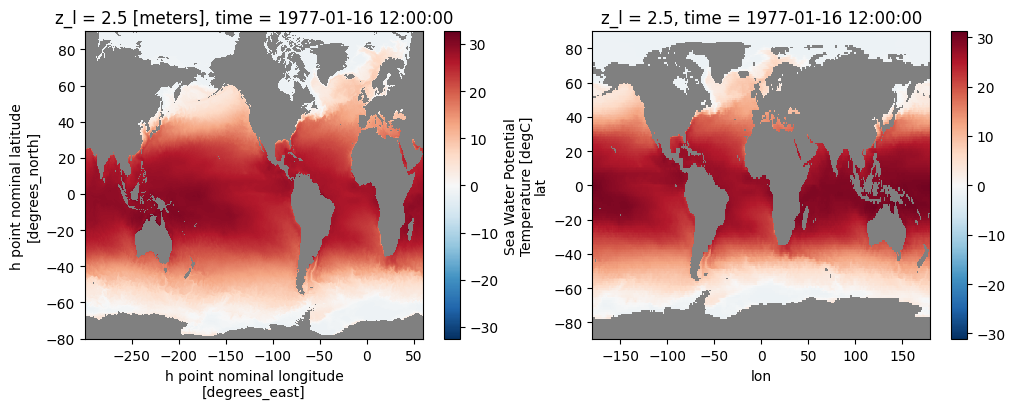

In [14]:
base_path = '/scratch/pp2681/mom6/OM4_SIS2/'
exp = 'unparameterized'
files = os.path.join(base_path,exp,'output','*ocean_month_z*')
ds = xr.open_mfdataset(files, chunks={'time':1})

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ds.thetao[0][0].plot()
plt.gca().set_facecolor('gray')
plt.subplot(1,2,2)
regridder(ds.thetao)[0][0].plot()
plt.gca().set_facecolor('gray')

# Vertical coarsegraining of WOA to OM4 grid
This is conservative vertical coarsegraining with piecewise-constant reconstruction

In [15]:
# Bounds of vertical grid cells in OM4
ds.z_i

<xarray.DataArray 'z_i' (z_i: 36)> Size: 288B
array([0.000e+00, 5.000e+00, 1.500e+01, 2.500e+01, 4.000e+01, 6.250e+01,
       8.750e+01, 1.125e+02, 1.375e+02, 1.750e+02, 2.250e+02, 2.750e+02,
       3.500e+02, 4.500e+02, 5.500e+02, 6.500e+02, 7.500e+02, 8.500e+02,
       9.500e+02, 1.050e+03, 1.150e+03, 1.250e+03, 1.350e+03, 1.450e+03,
       1.625e+03, 1.875e+03, 2.250e+03, 2.750e+03, 3.250e+03, 3.750e+03,
       4.250e+03, 4.750e+03, 5.250e+03, 5.750e+03, 6.250e+03, 6.750e+03])
Coordinates:
  * z_i      (z_i) float64 288B 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
Attributes:
    long_name:       Depth at interface
    units:           meters
    cartesian_axis:  Z
    positive:        down

In [16]:
# Vertical layer centroids in woa
woa_ptemp.depth

<xarray.DataArray 'depth' (depth: 102)> Size: 816B
array([0.00e+00, 5.00e+00, 1.00e+01, 1.50e+01, 2.00e+01, 2.50e+01, 3.00e+01,
       3.50e+01, 4.00e+01, 4.50e+01, 5.00e+01, 5.50e+01, 6.00e+01, 6.50e+01,
       7.00e+01, 7.50e+01, 8.00e+01, 8.50e+01, 9.00e+01, 9.50e+01, 1.00e+02,
       1.25e+02, 1.50e+02, 1.75e+02, 2.00e+02, 2.25e+02, 2.50e+02, 2.75e+02,
       3.00e+02, 3.25e+02, 3.50e+02, 3.75e+02, 4.00e+02, 4.25e+02, 4.50e+02,
       4.75e+02, 5.00e+02, 5.50e+02, 6.00e+02, 6.50e+02, 7.00e+02, 7.50e+02,
       8.00e+02, 8.50e+02, 9.00e+02, 9.50e+02, 1.00e+03, 1.05e+03, 1.10e+03,
       1.15e+03, 1.20e+03, 1.25e+03, 1.30e+03, 1.35e+03, 1.40e+03, 1.45e+03,
       1.50e+03, 1.55e+03, 1.60e+03, 1.65e+03, 1.70e+03, 1.75e+03, 1.80e+03,
       1.85e+03, 1.90e+03, 1.95e+03, 2.00e+03, 2.10e+03, 2.20e+03, 2.30e+03,
       2.40e+03, 2.50e+03, 2.60e+03, 2.70e+03, 2.80e+03, 2.90e+03, 3.00e+03,
       3.10e+03, 3.20e+03, 3.30e+03, 3.40e+03, 3.50e+03, 3.60e+03, 3.70e+03,
       3.80e+03, 3.90e+03, 4.00e+03, 4.10e+03, 4.20e+03, 4.30e+03, 4.40e+03,
       4.50e+03, 4.60e+03, 4.70e+03, 4.80e+03, 4.90e+03, 5.00e+03, 5.10e+03,
       5.20e+03, 5.30e+03, 5.40e+03, 5.50e+03])
Coordinates:
  * depth    (depth) float64 816B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:   depth
    bounds:          depth_bnds
    positive:        down
    units:           meters
    cartesian_axis:  Z

In [17]:
# Bounds of vertical grid cells in woa
np.unique(woa_ptemp.depth_bnds.values)

array([0.000e+00, 2.500e+00, 7.500e+00, 1.250e+01, 1.750e+01, 2.250e+01,
       2.750e+01, 3.250e+01, 3.750e+01, 4.250e+01, 4.750e+01, 5.250e+01,
       5.750e+01, 6.250e+01, 6.750e+01, 7.250e+01, 7.750e+01, 8.250e+01,
       8.750e+01, 9.250e+01, 9.750e+01, 1.125e+02, 1.375e+02, 1.625e+02,
       1.875e+02, 2.125e+02, 2.375e+02, 2.625e+02, 2.875e+02, 3.125e+02,
       3.375e+02, 3.625e+02, 3.875e+02, 4.125e+02, 4.375e+02, 4.625e+02,
       4.875e+02, 5.250e+02, 5.750e+02, 6.250e+02, 6.750e+02, 7.250e+02,
       7.750e+02, 8.250e+02, 8.750e+02, 9.250e+02, 9.750e+02, 1.025e+03,
       1.075e+03, 1.125e+03, 1.175e+03, 1.225e+03, 1.275e+03, 1.325e+03,
       1.375e+03, 1.425e+03, 1.475e+03, 1.525e+03, 1.575e+03, 1.625e+03,
       1.675e+03, 1.725e+03, 1.775e+03, 1.825e+03, 1.875e+03, 1.925e+03,
       1.975e+03, 2.050e+03, 2.150e+03, 2.250e+03, 2.350e+03, 2.450e+03,
       2.550e+03, 2.650e+03, 2.750e+03, 2.850e+03, 2.950e+03, 3.050e+03,
       3.150e+03, 3.250e+03, 3.350e+03, 3.450e+03, 

In [19]:
woa_thetao_om4 = xr.zeros_like(regridder(ds.thetao)[0])
woa_so_om4 = xr.zeros_like(regridder(ds.so)[0])
# These are integrated weights in OM4 array
dz = xr.zeros_like(ds.z_l)
for zl in range(35):
    # Vertical bounds in OM4 grid for a given layer
    OM4_bounds = (float(ds.z_i[zl]), float(ds.z_i[zl+1]))
    for depth in range(len(woa_ptemp.depth)):
        woa_bounds = woa_ptemp.depth_bnds[depth].values
        # Track three types of intersection of grid boxes
        # woa grid box is fully inside OM4 grid box
        _dz = 0.0
        if woa_bounds[0] >= OM4_bounds[0] and woa_bounds[1] <= OM4_bounds[1]:
            _dz = woa_bounds[1] - woa_bounds[0]
            print('Fully inside:', woa_bounds, OM4_bounds, 'dz:', _dz)
        elif woa_bounds[0] >= OM4_bounds[0] and woa_bounds[0] <= OM4_bounds[1]:
            _dz = OM4_bounds[1] - woa_bounds[0]
            print('Partially inside:', woa_bounds, OM4_bounds, 'dz:', _dz)
        elif woa_bounds[1] >= OM4_bounds[0] and woa_bounds[1] <= OM4_bounds[1]:
            _dz = woa_bounds[1] - OM4_bounds[0]
            print('Partially inside:', woa_bounds, OM4_bounds, 'dz:', _dz)

        if _dz > 0.:
            woa_thetao_om4[zl] += woa_ptemp_annual[depth] * _dz
            woa_so_om4[zl]     += woa_sal_annual[depth]   * _dz
            dz[zl] += _dz

woa_thetao_om4 = woa_thetao_om4 / dz
woa_so_om4 = woa_so_om4 / dz

Fully inside: [0.  2.5] (0.0, 5.0) dz: 2.5
Partially inside: [2.5 7.5] (0.0, 5.0) dz: 2.5
Partially inside: [2.5 7.5] (5.0, 15.0) dz: 2.5
Fully inside: [ 7.5 12.5] (5.0, 15.0) dz: 5.0
Partially inside: [12.5 17.5] (5.0, 15.0) dz: 2.5
Partially inside: [12.5 17.5] (15.0, 25.0) dz: 2.5
Fully inside: [17.5 22.5] (15.0, 25.0) dz: 5.0
Partially inside: [22.5 27.5] (15.0, 25.0) dz: 2.5
Partially inside: [22.5 27.5] (25.0, 40.0) dz: 2.5
Fully inside: [27.5 32.5] (25.0, 40.0) dz: 5.0
Fully inside: [32.5 37.5] (25.0, 40.0) dz: 5.0
Partially inside: [37.5 42.5] (25.0, 40.0) dz: 2.5
Partially inside: [37.5 42.5] (40.0, 62.5) dz: 2.5
Fully inside: [42.5 47.5] (40.0, 62.5) dz: 5.0
Fully inside: [47.5 52.5] (40.0, 62.5) dz: 5.0
Fully inside: [52.5 57.5] (40.0, 62.5) dz: 5.0
Fully inside: [57.5 62.5] (40.0, 62.5) dz: 5.0
Partially inside: [62.5 67.5] (40.0, 62.5) dz: 0.0
Partially inside: [57.5 62.5] (62.5, 87.5) dz: 0.0
Fully inside: [62.5 67.5] (62.5, 87.5) dz: 5.0
Fully inside: [67.5 72.5] (62.5, 

In [20]:
# Here we check that the calculated weights sum up to correct numbers (apart from the deepest layers)
print(np.diff(ds.z_i))
print(dz.values)
print((np.diff(ds.z_i) - dz).values)
# Note: we will keep only those layers where dz == np.diff(ds.z_i)

[  5.   10.   10.   15.   22.5  25.   25.   25.   37.5  50.   50.   75.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  175.
 250.  375.  500.  500.  500.  500.  500.  500.  500.  500.  500. ]
[  5.   10.   10.   15.   22.5  25.   25.   25.   37.5  50.   50.   75.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  175.
 250.  375.  500.  500.  500.  500.  500.  500.  250.    0.    0. ]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 250. 500. 500.]


In [49]:
#Fill with nans the last three OM4 layers because they have not enough of data
woa_thetao_om4[-3:] = np.nan
woa_so_om4[-3:] = np.nan
dz[-3:] = 0.

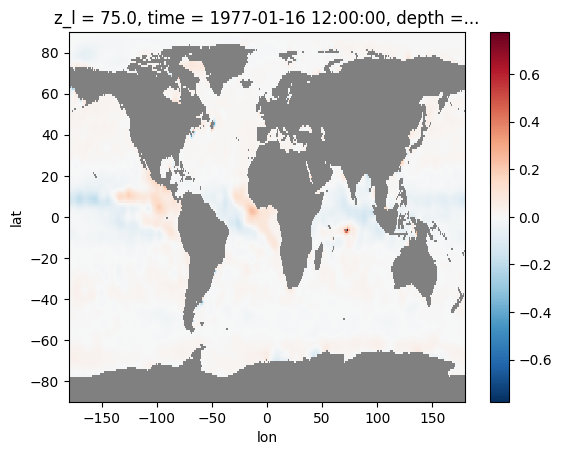

In [22]:
(woa_thetao_om4[5] - woa_ptemp_annual.interp(depth=ds.z_l)[5]).plot(robust=False)
plt.gca().set_facecolor('gray')

In [23]:
np.isnan(woa_thetao_om4[0]).sum().values

array(23729)

In [24]:
np.isnan(woa_so_om4[0]).sum().values

array(23729)

In [26]:
np.isnan(regridder(ds.thetao)[0][0]).sum().values

array(24963)

In [27]:
np.isnan(regridder(ds.so)[0][0]).sum().values

array(24963)

In [51]:
# Aggregate NaNs coming from OM4 and WOA
mask_nan = xr.where(np.isnan(woa_thetao_om4 * regridder(ds.thetao)[0]), np.nan, 1.0)

In [52]:
# Remove all information apart from 5 oceans
from cmip_basins import generate_basin_codes
basincodes = generate_basin_codes(woa_ptemp, lon='lon', lat='lat')
mask_oceans = xr.where(np.logical_and(basincodes>=1, basincodes<=5), 1., np.nan)

In [53]:
mask_nan = (mask_nan * mask_oceans).astype('float32')

In [54]:
(mask_nan * woa_thetao_om4).astype('float32').to_netcdf('../data-coarsegrain/woa_thetao.nc')

In [55]:
(mask_nan * woa_so_om4).astype('float32').to_netcdf('../data-coarsegrain/woa_so.nc')

## Create coarse grid metadata

In [57]:
dz

<xarray.DataArray 'z_l' (z_l: 35)> Size: 280B
array([  5. ,  10. ,  10. ,  15. ,  22.5,  25. ,  25. ,  25. ,  37.5,
        50. ,  50. ,  75. , 100. , 100. , 100. , 100. , 100. , 100. ,
       100. , 100. , 100. , 100. , 100. , 175. , 250. , 375. , 500. ,
       500. , 500. , 500. , 500. , 500. ,   0. ,   0. ,   0. ])
Coordinates:
  * z_l      (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03

In [58]:
# Horizontal coarse grid
param_coarse = xr.Dataset()

R = 6.371e+6 
# Zonal distance (dx) varies with latitude
param_coarse['mask_nan'] = mask_nan
param_coarse['dy'] = R * np.deg2rad(1.)
param_coarse['dx'] = np.cos(np.deg2rad(mask_nans.lat)) * param_coarse['dy']
param_coarse['dz'] = dz
param_coarse['dS'] = param_coarse['dx'] * param_coarse['dy']
param_coarse['dV'] = param_coarse['dx'] * param_coarse['dy'] * param_coarse['dz'] * param_coarse['mask_nan']

In [64]:
param_coarse.transpose('z_l','lat','lon')

<xarray.Dataset> Size: 27MB
Dimensions:   (z_l: 35, lon: 360, lat: 180)
Coordinates:
  * z_l       (z_l) float64 280B 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    time      object 8B 1977-01-16 12:00:00
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    mask_nan  (z_l, lat, lon) float32 9MB dask.array<chunksize=(35, 180, 360), meta=np.ndarray>
    dy        float64 8B 1.112e+05
    dx        (lat) float64 1kB 970.3 2.911e+03 4.85e+03 ... 2.911e+03 970.3
    dz        (z_l) float64 280B 5.0 10.0 10.0 15.0 22.5 ... 500.0 0.0 0.0 0.0
    dS        (lat) float64 1kB 1.079e+08 3.237e+08 ... 3.237e+08 1.079e+08
    dV        (z_l, lat, lon) float64 18MB dask.array<chunksize=(35, 180, 360), meta=np.ndarray>

In [66]:
param_coarse.transpose('z_l','lat','lon').to_netcdf('../data-coarsegrain/param_coarse.nc')